# A subgraph-based test

We will compare the number of triangle subcounts in two unmatched networks.

## Preliminaries

In [13]:
# import modules
from pkg.utils import set_warnings
set_warnings()

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotmotif import Motif, GrandIsoExecutor
import networkx as nx
import random
from myst_nb import glue

from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import savefig
from pkg.plot import set_theme
from pkg.utils import get_seeds

In [24]:
# load data
t0 = time.time()
set_theme(font_scale=0.75)

left_adj, left_nodes = load_unmatched("left")
right_adj, right_nodes = load_unmatched("right")

left_nodes["inds"] = range(len(left_nodes))
right_nodes["inds"] = range(len(right_nodes))

seeds = get_seeds(left_nodes, right_nodes)

## Compute the difference in triangle subgraph counts

We subsampled edges from the right hemisphere to correct for the difference in density, then counted the number of triangle subgraphs in each network using the [dotmotif](https://github.com/aplbrain/dotmotif) package. 500 different subsamples were generated randomly, and the distribution of the difference in subgraph counts were plotted.

In [21]:
# compute density correction
n_edges_left = np.count_nonzero(left_adj)
n_edges_right = np.count_nonzero(right_adj)
n_left = left_adj.shape[0]
n_right = right_adj.shape[0]
density_left = n_edges_left / (n_left ** 2)
density_right = n_edges_right / (n_right ** 2)

n_remove = int((density_right - density_left) * (n_right ** 2))

glue("density_left", density_left, display=False)
glue("density_right", density_right, display=False)
glue("n_remove", n_remove, display=False)

In [22]:
stats = []
left_g = nx.from_numpy_matrix(left_adj, create_using=nx.DiGraph)
n_resamples = 500
glue("n_resamples", n_resamples, display=False)

for i in range(n_resamples):
    edge_remove_idx = random.sample(range(1, n_edges_right), n_remove)
    remove_idx = tuple(np.array(np.nonzero(right_adj))[:, edge_remove_idx])

    subsampled_right_adj = right_adj.copy()
    subsampled_right_adj[remove_idx] = 0
    subsampled_right_g = nx.from_numpy_matrix(subsampled_right_adj, create_using=nx.DiGraph)

    triangle = Motif("""
    A -> B
    B -> C
    C -> A
    """)

    left_executor = GrandIsoExecutor(graph=left_g)
    left_counts = left_executor.count(triangle)

    right_executor = GrandIsoExecutor(graph=subsampled_right_g)
    right_counts = right_executor.count(triangle)

    stat = left_counts - right_counts
    stats.append(stat)

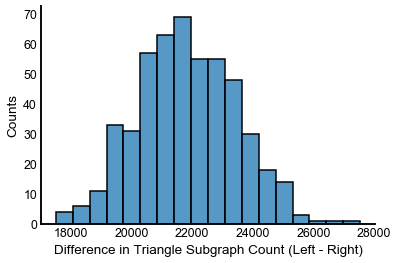

In [27]:
fig, ax = plt.subplots(1, 1)
sns.histplot(data=stats, ax=ax)
ax.set_xlabel("Difference in Triangle Subgraph Count (Left - Right)")
ax.set_ylabel("Counts")

#plt.savefig('triangle_count_distribution.jpg')